In [1]:
# Import modules
import tweepy as tw
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.validators import *
import plotly.offline as pyo
pyo.init_notebook_mode()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import unidecode as udec
from wordcloud import WordCloud
from collections import Counter
import json

## Get data from Twitter API

**Setup API credentials**

In [4]:
class ConnectAPI:
    """
    - consumer_key: The consumer key from the Twitter developer account (str)
    - consumer_secret: The consumer secret key from the Twitter developer account (str)
    - access_token: The access token from the Twitter developer account (str)
    - access_token_secret: The access token secret from the Twitter developer account (str)
    """
    
    # Insert API keys
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret):
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret
        
    # Authenticate and connect to Twitter
    def connect(self):
        self.auth = tw.OAuthHandler(self.consumer_key, self.consumer_secret)
        self.auth.set_access_token(self.access_token, self.access_token_secret)
        # Setup API connection
        self.api = tw.API(self.auth, parser=tw.parsers.JSONParser(), wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        # Verify connection
        try:
            self.api.verify_credentials()
            print("Authentication OK")
        except:
            print("Error during authentication")   
        return self.api

In [5]:
# Load JSON with tokens
keys_dict = json.load(open('../data/tokens_twitter.json'))

# Setup credentials
api_credentials = ConnectAPI(consumer_key= keys_dict['consumer_key'],
                             consumer_secret= keys_dict['consumer_secret'],
                             access_token= keys_dict['access_token'],
                             access_token_secret= keys_dict['access_token_secret'])
# Authenticate and connect
api = api_credentials.connect()

Authentication OK


**Get followers**

In [116]:
# Get follower IDs
followers = api.followers_ids(screen_name='marielle_paul', count=100)['ids']
print(f'Total number of followers: {len(followers)}')

Total number of followers: 100


**Get follower Tweets**

In [110]:
# Lists to store creation date en tweet text
created_at_list = []
text_list = []

In [111]:
# Retrieve tweets for followers
for follower in followers:
    try:
        timeline = api.user_timeline(user_id=follower, tweet_mode='extended')
        for tweet in timeline:
            created_at_list.append(tweet['created_at'])
            text_list.append(tweet['full_text']) 
    except:
        print(f"Tweets hidden for: {follower}")    

Tweets hidden for: 804814106


In [113]:
# Create dataframe with follower tweets
tweets_df = pd.DataFrame({'created_at': created_at_list,
                          'tweet': text_list
                         }
                        )

In [115]:
print(f'Total number of collected tweets: {len(tweets_df)}')

Total number of collected tweets: 1747


In [117]:
tweets_df.head()

created_at  \
0  Fri Feb 19 13:56:26 +0000 2021   
1  Fri Feb 19 06:28:23 +0000 2021   
2  Thu Feb 18 19:15:01 +0000 2021   
3  Thu Feb 18 15:49:46 +0000 2021   
4  Thu Feb 18 09:58:03 +0000 2021   

                                               tweet  
0  RT @dhcluchtmacht: Woensdag voerden zes Cougar...  
1  RT @JoelPostma: Leuk inkijkje in een prachtig ...  
2  RT @MinBijleveld: Ook nieuwe Amerikaanse Defen...  
3  Vanmiddag op ronde door de KMSL/ @VlbWoensdrec...  
4  Vanochtend op de KMA @NLDA_DOSCO in gesprek me...

## Preprocess

In [175]:
class PreProcessing:

    # Change dtype created_at to datetime
    def change_dtype(dataf):

        dtype_df = dataf.assign(created_at = lambda d: pd.to_datetime(d['created_at']))

        return dtype_df
    
    # Add short date annotation 
    def format_date(dataf):

        format_date_df = dataf.assign(created_at_short = lambda d: pd.to_datetime(d['created_at'].dt.strftime('%Y/%m/%d')))

        return format_date_df

    # Reorder columns
    def reorder_cols(dataf):

        return dataf[['created_at', 'created_at_short', 'tweet']]
    
    # Add date parts 
    def add_date_parts(dataf):

        datepart_df = dataf.assign(hour = lambda d: d['created_at'].dt.hour,
                                   day_name = lambda d: d['created_at'].dt.strftime('%A'),
                                   day_number = lambda d: d['created_at'].dt.dayofweek,
                                   month_name = lambda d: d['created_at'].dt.strftime('%B'),
                                   month_number = lambda d: d['created_at'].dt.month,
                                   year = lambda d: d['created_at'].dt.year
                                  )
        return datepart_df
    
    # Add count
    def add_count(dataf):

        count_df = dataf.assign(count = 1)

        return count_df
    
    # Filter dates
    def filter_dates(dataf, start_date, end_date):
        
        return dataf[(dataf['created_at_short'] >= start_date) & (dataf['created_at_short'] <= end_date)]

     
    # Clean tweet text and store word frequencies in dictionary
    def clean_store_words(dataf):
        
        # Concatenate texts from all tweets in single string, make lowercase
        total_text = dataf['tweet'].str.cat().lower()
        
        # Remove special characters and single letters using tokenizer
        tokenizer = RegexpTokenizer(r'\w{2,}')    
        total_text_tokens = tokenizer.tokenize(total_text)

        # Stopwords to remove
        stopwords_nl = nltk.corpus.stopwords.words('dutch')
        stopwords_en = nltk.corpus.stopwords.words('english')
                       
        # Other user defined words to remove 
        other_stopwords = (['rt','we', 'co', 'https', 'http', 'vvd', 'wel', 'komt', 'weer', 'gaat', 'jij', 'via', 'waar', 'staat', 'maken', 'mee', 'gaan', 'even', 'onze',                                       'vandaag', 'mensen', 'goed', 'dank', 'iedereen', 'alle', 'amp', 'moeten', 'eerste', 'tijd', 'jaar', 'heel', 'dag', 'echt', 'wij', 'nieuwe', 'mooi',                                  'mooie', 'new', 'week', 'jullie'])
        
        # Keep relevant words
        tokens_no_stopwords = [word for word in total_text_tokens if not word in stopwords_nl and not word in stopwords_en and not word in other_stopwords]
        
        # Store word frequencies in dictionary
        words_dict = Counter(tokens_no_stopwords)

        return words_dict

    

In [176]:
# Create clean dataframe
clean_tweets_df = (tweets_df
                      .pipe(PreProcessing.change_dtype)
                      .pipe(PreProcessing.format_date)
                      .pipe(PreProcessing.reorder_cols)
                      .pipe(PreProcessing.add_date_parts)
                      .pipe(PreProcessing.add_count)
                      .pipe(PreProcessing.filter_dates, start_date='2021-01-01', end_date='2021-02-14')
                  )

In [177]:
clean_tweets_df.head()

created_at created_at_short  \
10 2021-02-14 17:51:12+00:00       2021-02-14   
11 2021-02-14 17:46:55+00:00       2021-02-14   
12 2021-02-13 12:15:21+00:00       2021-02-13   
13 2021-02-12 18:24:11+00:00       2021-02-12   
14 2021-02-12 16:45:36+00:00       2021-02-12   

                                                tweet  hour  day_name  \
10  Wat een paar mooie schaatsdagen! https://t.co/...    17    Sunday   
11  RT @sandersierdsma: Geen idee wie Rick is maar...    17    Sunday   
12  @cvanstijn Nee hoor, kwestie van hard doorscha...    12  Saturday   
13  Dit gevoel...vandaag op de Kaag ook op zulk pr...    18    Friday   
14  RT @Defensie: Cougar-loadmaster adjudant Jean ...    16    Friday   

    day_number month_name  month_number  year  count  
10           6   February             2  2021      1  
11           6   February             2  2021      1  
12           5   February             2  2021      1  
13           4   February             2  2021      1  
14           4   February             2  2021      1

In [178]:
# Create grouped dataframes per date part
tweets_df_month = (clean_tweets_df
                        .groupby(['month_name', 'month_number'])
                        .sum()
                        .reset_index()
                        .sort_values(by='month_number', ascending=True)
                        [['month_name', 'count']]
                  )

tweets_df_day = (clean_tweets_df
                        .groupby(['day_name', 'day_number'])
                        .sum()
                        .reset_index()
                        .sort_values(by='day_number', ascending=True)
                        [['day_name', 'count']]
                )

tweets_df_hour = (clean_tweets_df
                        .groupby('hour')
                        .sum()
                        .reset_index()
                        [['hour', 'count']]
                 )

tweets_df_day_hour = (clean_tweets_df
                              .pivot_table(index='hour', columns='day_name', values='count', aggfunc='sum', fill_value=0)
                              [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
                     )

In [152]:
# Create clean words dictionary for WordCloud
words_dict = clean_tweets_df.pipe(PreProcessing.clean_store_words)

## Visualize

**Activity per date part**

In [181]:
# Plot the activity per grouped data frame
for df in [tweets_df_month, tweets_df_day, tweets_df_hour]:
    
    fig = px.bar(data_frame=df,
                 x=df.columns[0],
                 y=df.columns[-1],
                 color=df.columns[-1],
                 color_continuous_scale='blugrn',
                 #text=df.columns[-1],
                 title=f'Activity from followers by {df.columns[0]}'
                )
    
    fig.update_traces(textposition='outside')
    
    fig.update_layout(title={'y':0.88,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'
                            }
                     )
    
    fig.update_xaxes(title='')
    fig.update_yaxes(title='Tweets or Retweets')
    

    fig.show()

In [182]:
# Heatmap to show activity by day & hour
fig = px.imshow(tweets_df_day_hour.values,
                labels=dict(x='Day of Week', y='Hour', color='# of Tweets or Retweets'),
                x=tweets_df_day_hour.columns,
                y=tweets_df_day_hour.index,
                color_continuous_scale='reds',
                title='Activity from folowers by day & hour',
                width=1000, height=600
                )

fig.update_layout(title={'y':0.88,
                         'x':0.45,
                         'xanchor': 'center',
                         'yanchor': 'top'
                        }
                 )
fig.show()

**Common topics**

In [183]:
class WordCloudModel:
    
    def __init__(self, width, height, background_color):
        """
        - width: The width of the wordcloud (int)
        - height: The height of the wordcloud (int)
        - background_color: The color of the wordcloud background (str)
        """
        
        self.width = width
        self.height = height
        self.background_color =  background_color

        
    def draw_wordcloud(self, dict_words, figsize):
        
        self.dict_words = dict_words
        self.figsize = figsize
        
        self.wordcloud = WordCloud(width=self.width, 
                                   height=self.height,
                                   background_color=self.background_color)
                         
        
        self.wordcloud.fit_words(dict_words)
        
        self.wordcloud.recolor(random_state=8)
        
        plt.figure(figsize = self.figsize, facecolor = None)
        plt.imshow(self.wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)

In [184]:
wordcloud = WordCloudModel(width=1024, 
                           height=768, 
                           background_color='white'
                          )

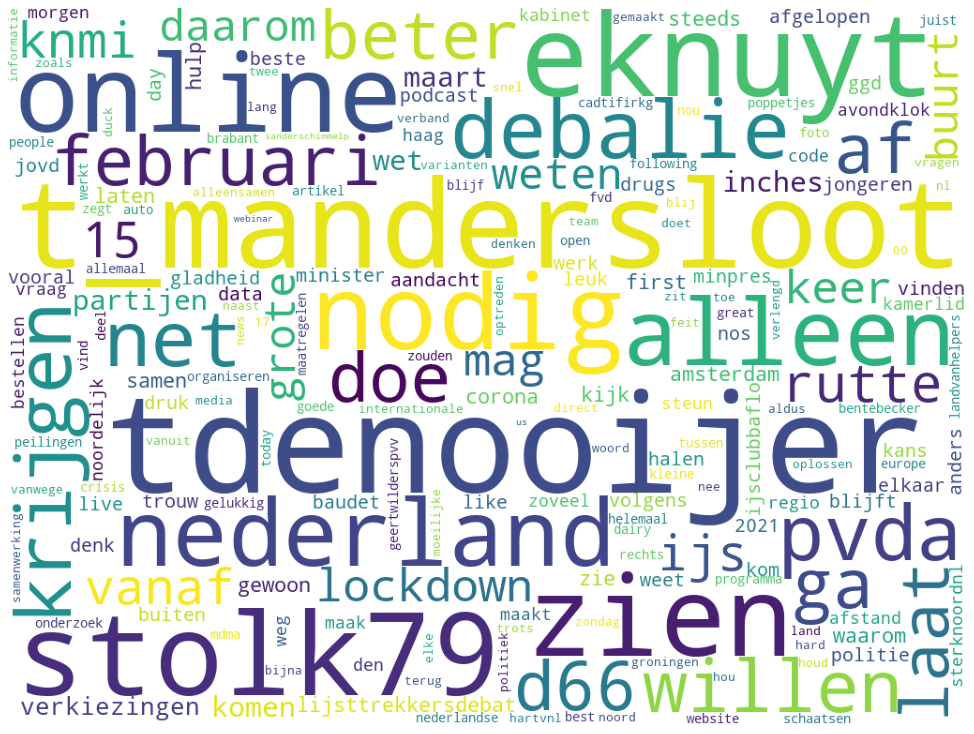

In [185]:
wordcloud.draw_wordcloud(words_dict, (20,10))